In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3


sns.set(style="whitegrid")
%matplotlib inline

In [2]:
db_path = "/content/bmarket.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM bank_marketing", conn)
conn.close()

# Check the first few rows
df.head()


,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no


In [3]:
df.shape
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  object
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           16399 non-null  object
 7   Personal Loan          37042 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.8+ MB


In [4]:
# Number of missing values
df.isnull().sum()

,0
Client ID,0
Age,0
Occupation,0
Marital Status,0
Education Level,0
Credit Default,0
Housing Loan,24789
Personal Loan,4146
Contact Method,0
Campaign Calls,0


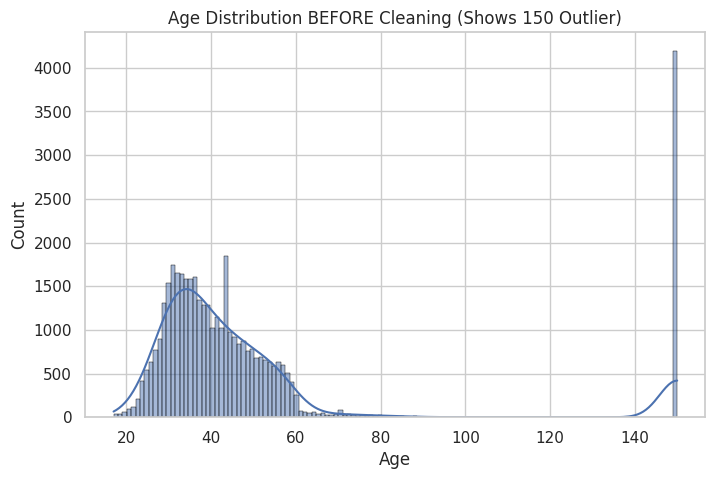

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df['Age'].str.replace(" years", "").astype(int),
             kde=True, edgecolor='black')
plt.title("Age Distribution BEFORE Cleaning (Shows 150 Outlier)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()



Data Cleaning

# Correcting Age Outliers

The age of 150 is clearly an erroneous entry. We will replace these outlier values with the median age of the dataset to maintain the overall distribution as much as possible.

In [6]:
# 1. Clean the 'Age' column
df['Age'] = df['Age'].str.replace(' years', '', regex=False).astype(int)

# 2. Create a distribution excluding age 150
valid_age_dist = df[df['Age'] != 150]['Age']

# 3. Randomly sample replacements for each invalid age
num_invalid = (df['Age'] == 150).sum()

replacement_values = np.random.choice(valid_age_dist, size=num_invalid, replace=True)

# 4. Replace the invalid values
df.loc[df['Age'] == 150, 'Age'] = replacement_values

# Optional — verify
print("New max age:", df['Age'].max())
print("Check count of 150 ages:", (df['Age'] == 150).sum())


New max age: 98
Check count of 150 ages: 0


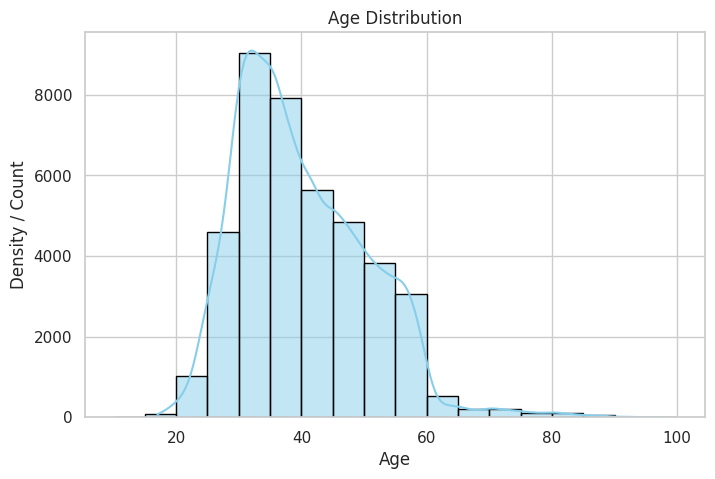

In [7]:
sns.set(style="whitegrid")

min_age = int(df['Age'].min() // 10 * 10)
max_age = int(df['Age'].max() // 10 * 10 + 10)
bins = range(min_age, max_age + 1, 5)

plt.figure(figsize=(8,5))
sns.histplot(df['Age'], bins=bins, kde=True, edgecolor='black', color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Density / Count")
plt.show()

In [8]:

df.describe()


,Client ID,Age,Campaign Calls,Previous Contact Days
count,41188.00000,41188.000000,41188.000000,41188.000000
mean,20594.50000,40.027022,2.051374,962.475454
std,11890.09578,10.447167,3.171345,186.910907
min,1.00000,17.000000,-41.000000,0.000000
25%,10297.75000,32.000000,1.000000,999.000000
50%,20594.50000,38.000000,2.000000,999.000000
75%,30891.25000,47.000000,3.000000,999.000000
max,41188.00000,98.000000,56.000000,999.000000


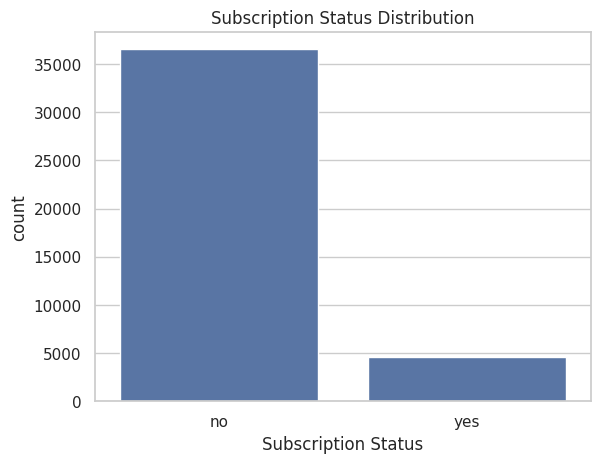

,proportion
Subscription Status,
no,0.887346
yes,0.112654


In [9]:
sns.countplot(x='Subscription Status', data=df)
plt.title("Subscription Status Distribution")
plt.show()

df['Subscription Status'].value_counts(normalize=True)

Distribution of Categorical features

# **Univariate Analysis**

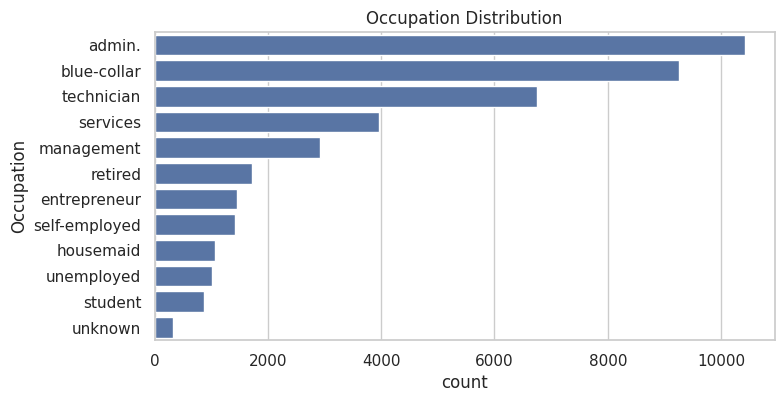

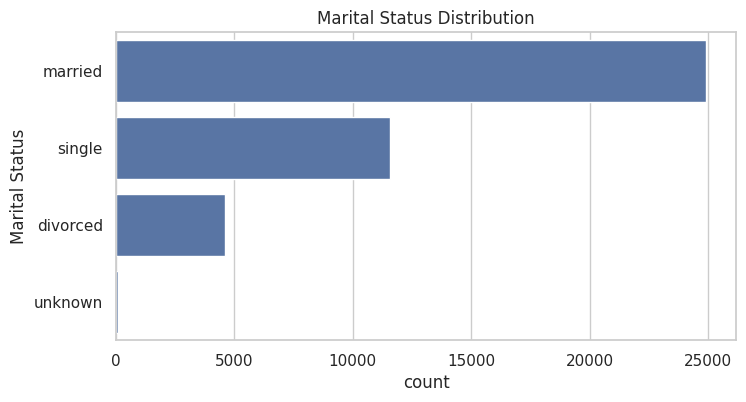

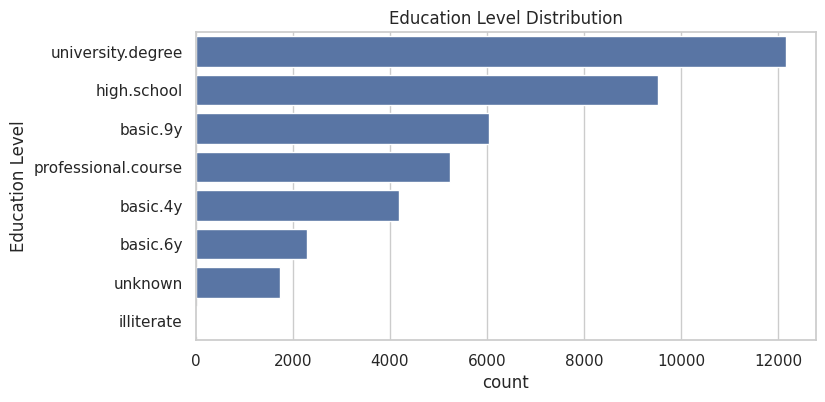

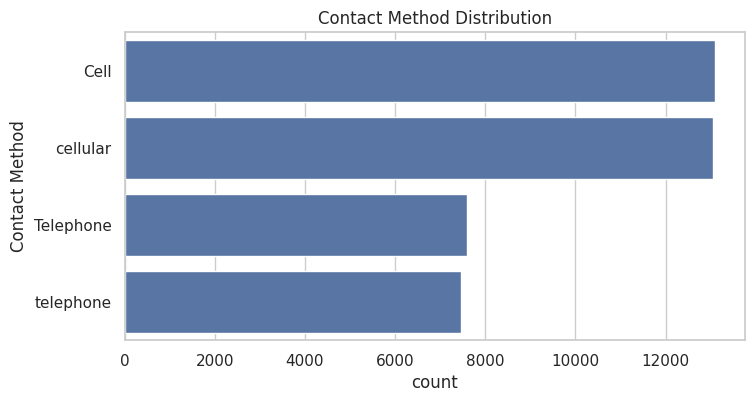

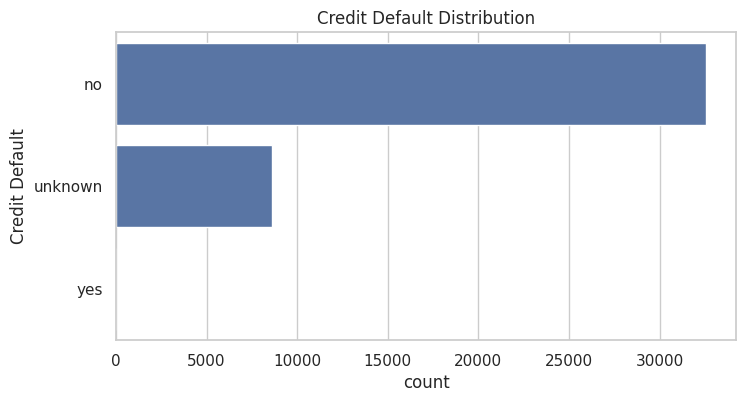

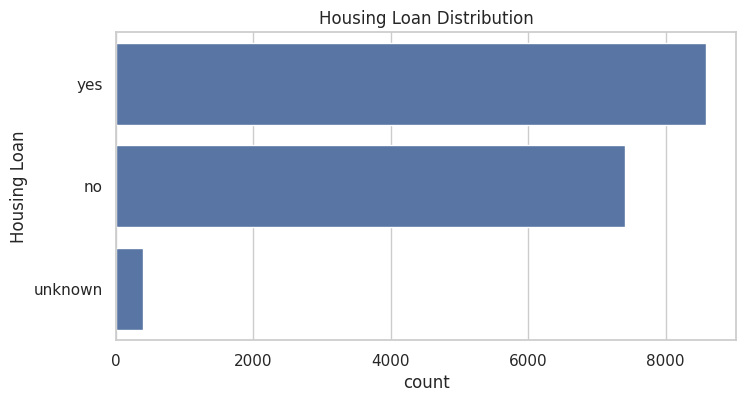

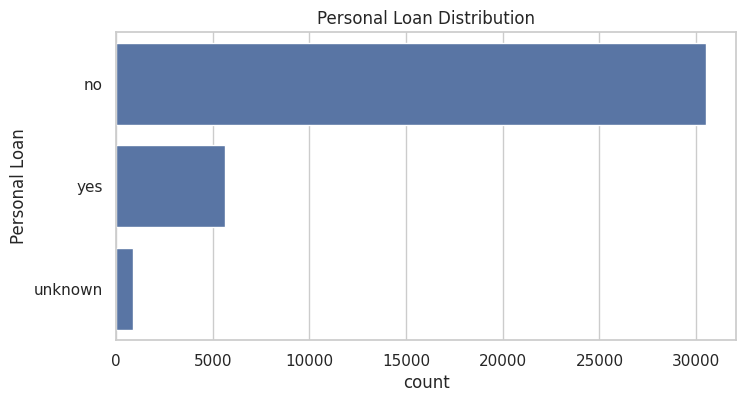

In [10]:
categorical_cols = ['Occupation', 'Marital Status', 'Education Level',
                    'Contact Method', 'Credit Default',
                    'Housing Loan', 'Personal Loan']

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"{col} Distribution")
    plt.show()


In [11]:
categorical_cols = ['Occupation', 'Marital Status', 'Education Level',
                    'Contact Method', 'Credit Default',
                    'Housing Loan', 'Personal Loan']

print("Count of 'unknown' values in categorical columns:")
for col in categorical_cols:
    unknown_count = df[df[col] == 'unknown'].shape[0]
    print(f"  {col}: {unknown_count}")

Count of 'unknown' values in categorical columns:
  Occupation: 330
  Marital Status: 80
  Education Level: 1731
  Contact Method: 0
  Credit Default: 8597
  Housing Loan: 393
  Personal Loan: 877


In [12]:
illiterate_count = df[df['Education Level'] == 'illiterate'].shape[0]
print(f"Number of 'illiterate' entries in 'Education Level': {illiterate_count}")

Number of 'illiterate' entries in 'Education Level': 18


In [13]:
def replace_unknown_with_distribution(df, column_name, unknown_label='unknown'):
    """
    Replace 'unknown' in a categorical column by sampling from the
    existing distribution of known values.
    """

    # Known values (exclude 'unknown')
    known = df[df[column_name] != unknown_label][column_name]

    # If nothing to sample from, skip
    if known.empty:
        print(f"Column '{column_name}' has no known values — skipped.")
        return df

    # Count how many unknowns
    n_unknown = (df[column_name] == unknown_label).sum()

    if n_unknown == 0:
        print(f"No 'unknown' values found in '{column_name}'.")
        return df

    # Probability distribution of known categories
    probabilities = known.value_counts(normalize=True)

    # Sample replacements
    replacements = np.random.choice(
        probabilities.index,
        size=n_unknown,
        p=probabilities.values
    )

    # Replace the unknowns
    df.loc[df[column_name] == unknown_label, column_name] = replacements

    print(f"Replaced {n_unknown} 'unknown' values in '{column_name}'.")

    return df

In [14]:
categorical_columns = [
    'Occupation',
    'Marital Status',
    'Education Level',
    'Credit Default',
    'Housing Loan',
    'Personal Loan'
]

for col in categorical_columns:
    df = replace_unknown_with_distribution(df, col)


Replaced 330 'unknown' values in 'Occupation'.
Replaced 80 'unknown' values in 'Marital Status'.
Replaced 1731 'unknown' values in 'Education Level'.
Replaced 8597 'unknown' values in 'Credit Default'.
Replaced 393 'unknown' values in 'Housing Loan'.
Replaced 877 'unknown' values in 'Personal Loan'.


after replacing the unknown

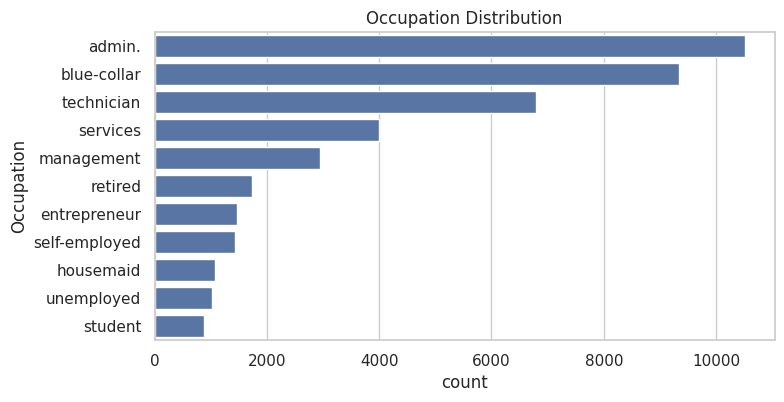

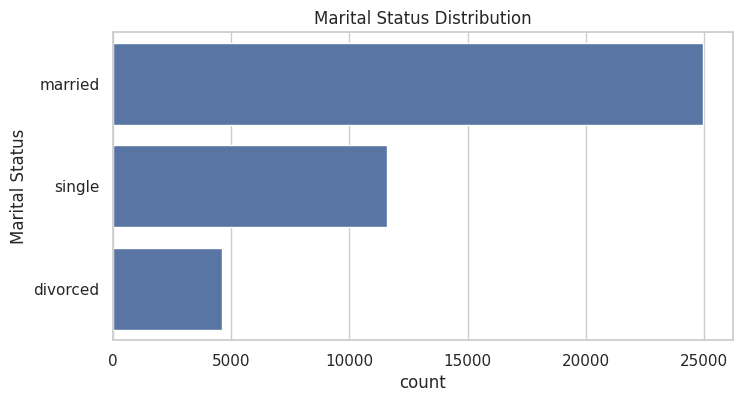

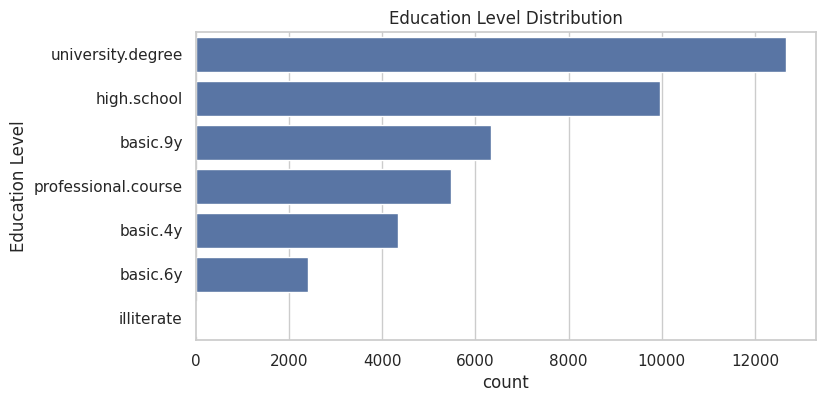

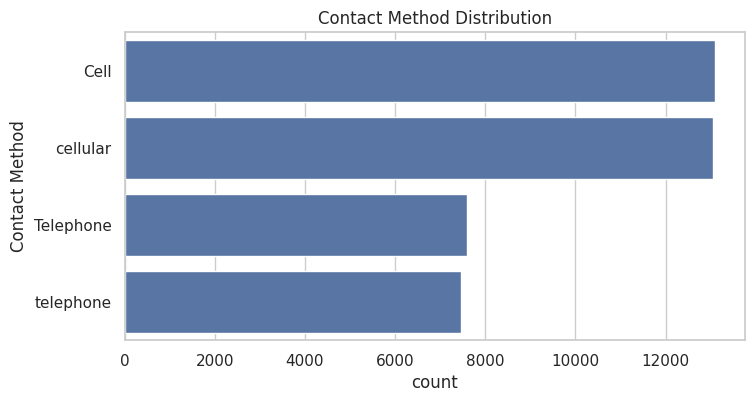

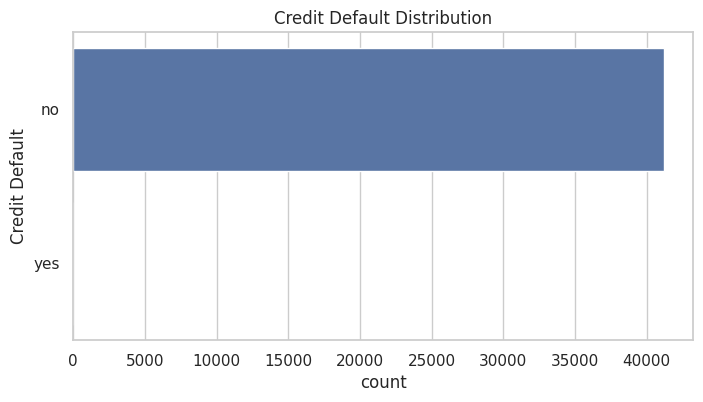

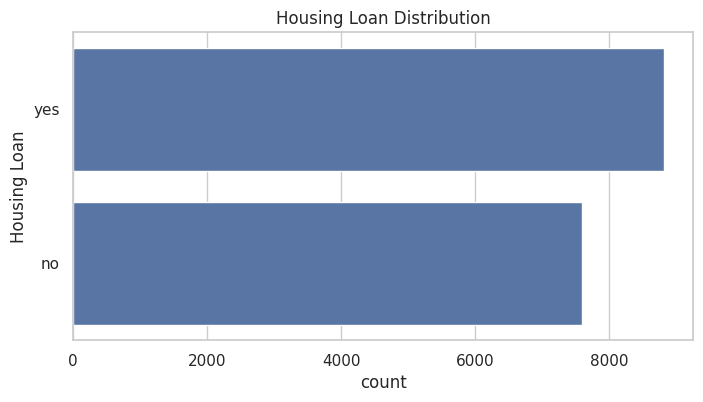

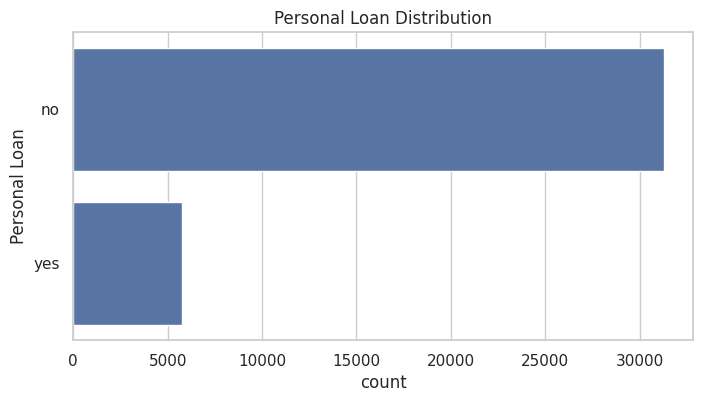

In [15]:
categorical_cols = ['Occupation', 'Marital Status', 'Education Level',
                    'Contact Method', 'Credit Default',
                    'Housing Loan', 'Personal Loan']

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"{col} Distribution")
    plt.show()

# **Birivative Analysis ( need to make graph look nicer)**

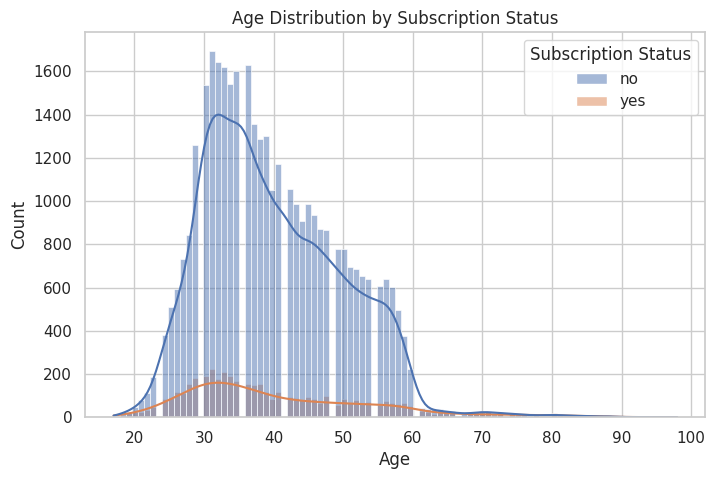

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Age', hue='Subscription Status', kde=True, alpha=0.5)
plt.title("Age Distribution by Subscription Status")
plt.show()



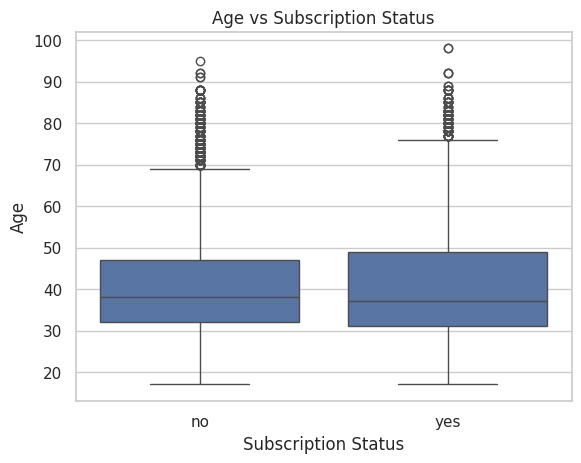

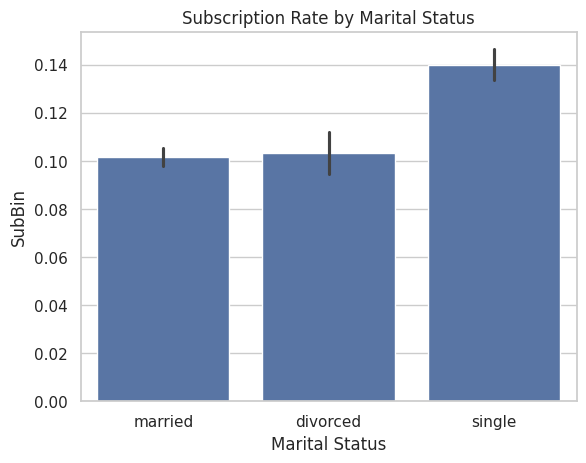

In [18]:
sns.boxplot(x='Subscription Status', y='Age', data=df)
plt.title("Age vs Subscription Status")
plt.show()

df['SubBin'] = df['Subscription Status'].map({'yes': 1, 'no': 0})
sns.barplot(x='Marital Status', y='SubBin', data=df)
plt.title("Subscription Rate by Marital Status")
plt.show()

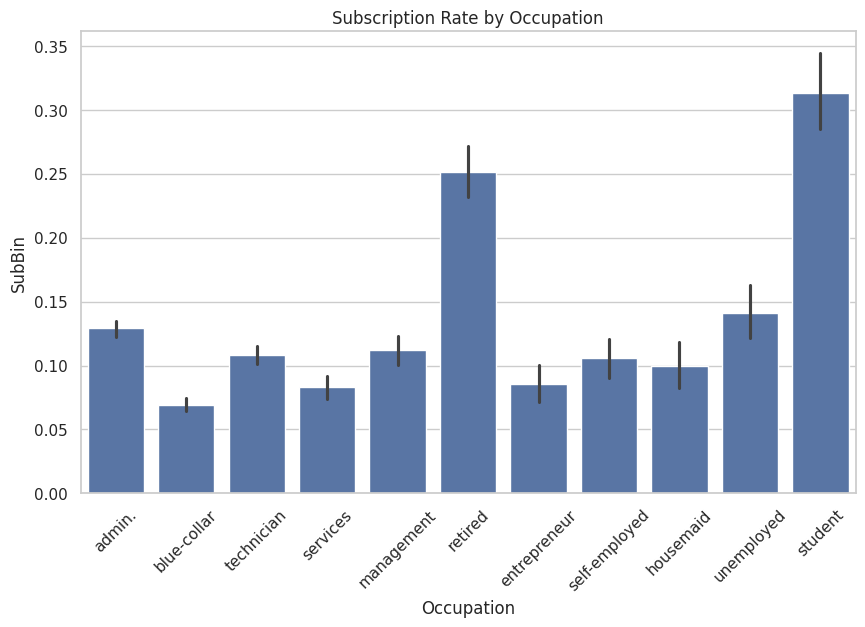

In [19]:
# Convert Subscription Status into binary 1/0
df['SubBin'] = df['Subscription Status'].map({'yes': 1, 'no': 0})
plt.figure(figsize=(10,6))
sns.barplot(x='Occupation', y='SubBin', data=df, order=df['Occupation'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Subscription Rate by Occupation")
plt.show()


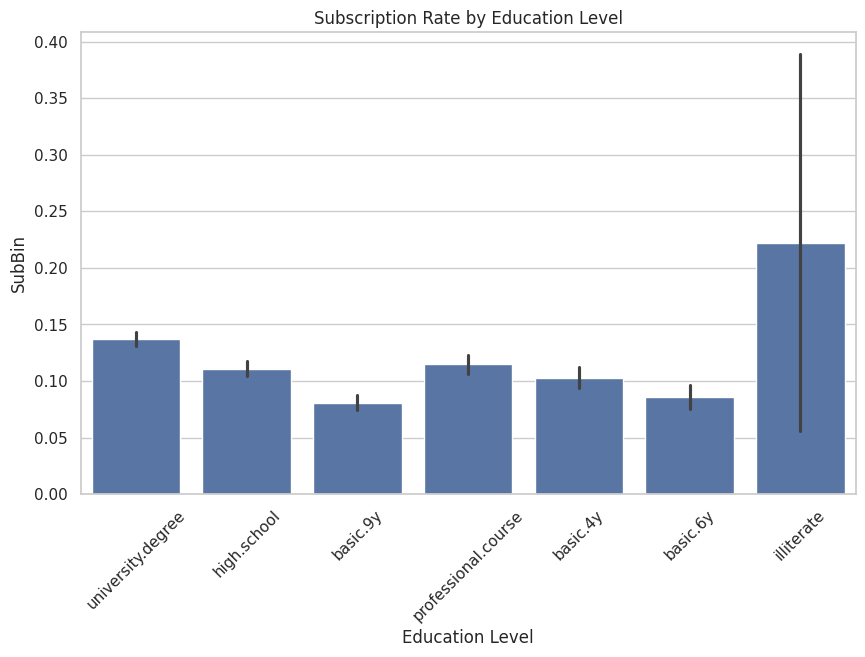

In [20]:
plt.figure(figsize=(10,6))
sns.barplot(x='Education Level', y='SubBin', data=df, order=df['Education Level'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Subscription Rate by Education Level")
plt.show()


In [21]:
# Combine the cell and cellular column together
df['Contact Method'] = df['Contact Method'].replace({
    'cellular': 'Cell'
})
# Combine the Telephone and telephone column together
df['Contact Method'] = df['Contact Method'].replace({
    'telephone': 'Telephone'
})

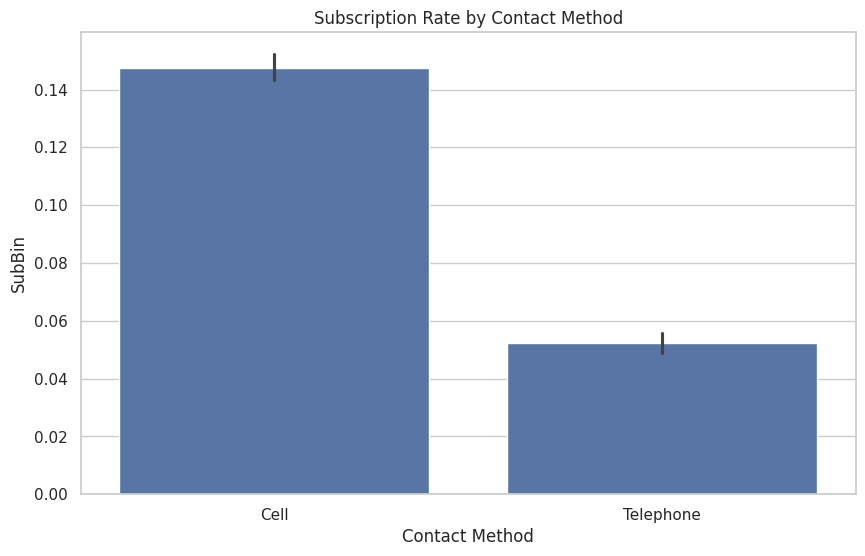

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(x='Contact Method', y='SubBin', data=df, order=df['Contact Method'].value_counts().index)
plt.title("Subscription Rate by Contact Method")
plt.show()




---



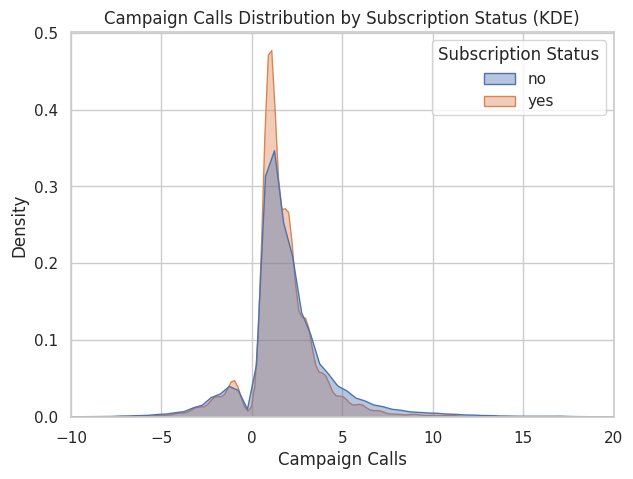

In [23]:
plt.figure(figsize=(7,5))
sns.kdeplot(
    data=df,
    x="Campaign Calls",
    hue="Subscription Status",
    fill=True,
    common_norm=False,
    alpha=0.4
)
plt.xlim(-10, 20)
plt.title("Campaign Calls Distribution by Subscription Status (KDE)")
plt.show()


since negative compaign calls are impossible, we would replace

In [24]:
# 1. Extract valid distribution (>= 0)
valid_calls = df[df['Campaign Calls'] >= 0]['Campaign Calls']

# 2. Count how many invalid (negative) values
n_invalid = (df['Campaign Calls'] < 0).sum()

print("Number of invalid negative values:", n_invalid)

# 3. Sample from real distribution
replacement_values = np.random.choice(valid_calls, size=n_invalid, replace=True)

# 4. Replace the negative values
df.loc[df['Campaign Calls'] < 0, 'Campaign Calls'] = replacement_values

print("Negative campaign call values replaced.")


Number of invalid negative values: 4153
Negative campaign call values replaced.


after replacing the negative values

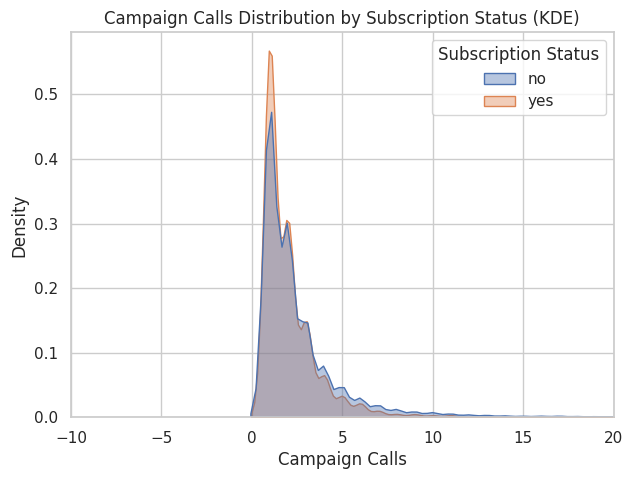

In [25]:
plt.figure(figsize=(7,5))
sns.kdeplot(
    data=df,
    x="Campaign Calls",
    hue="Subscription Status",
    fill=True,
    common_norm=False,
    alpha=0.4
)
plt.xlim(-10, 20)
plt.title("Campaign Calls Distribution by Subscription Status (KDE)")
plt.show()

Previous contact days by subscription status

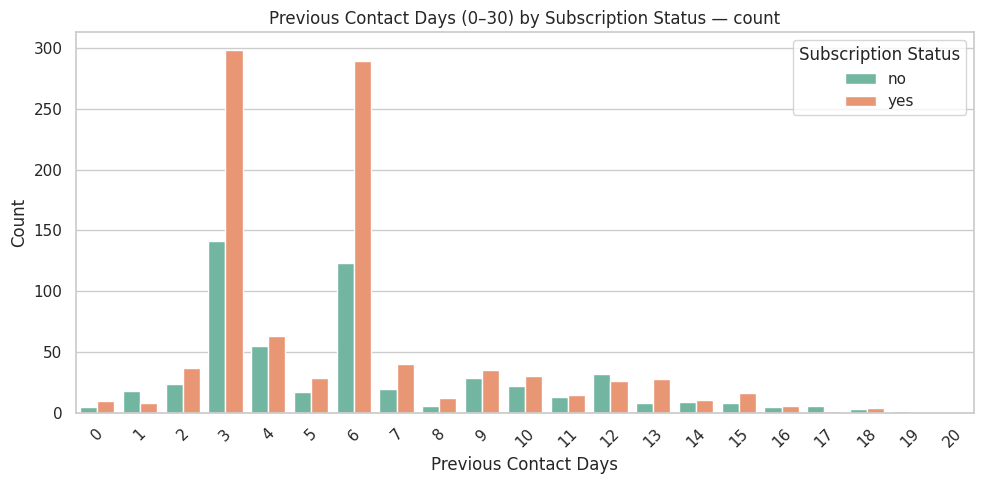

In [26]:
# Filtered out 999 values and limit to 20 days
df_prev = df[(df['Previous Contact Days'] != 999) &
             (df['Previous Contact Days'].between(0, 20))]

plt.figure(figsize=(10,5))

sns.countplot(
    data=df_prev,
    x='Previous Contact Days',
    hue='Subscription Status',
    palette='Set2'
)

plt.title("Previous Contact Days (0–30) by Subscription Status — count")
plt.xlabel("Previous Contact Days")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




---



Age vs Subscription

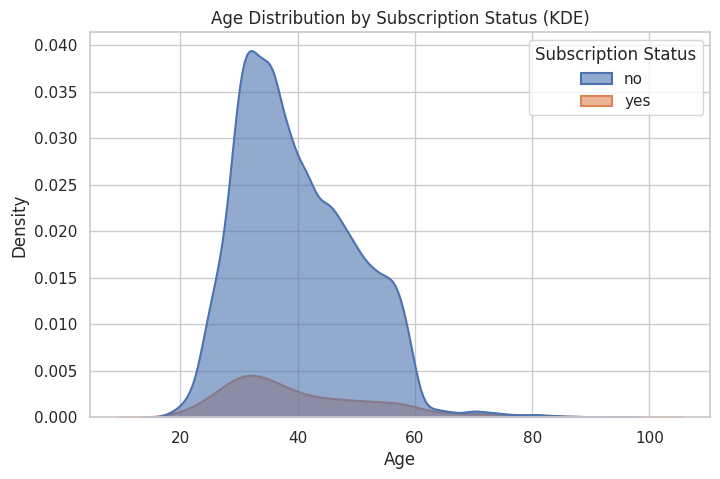

In [27]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='Age', hue='Subscription Status', fill=True, linewidth=1.5, alpha=0.6)
plt.title("Age Distribution by Subscription Status (KDE)")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()


Campaign Calls vs Subscription

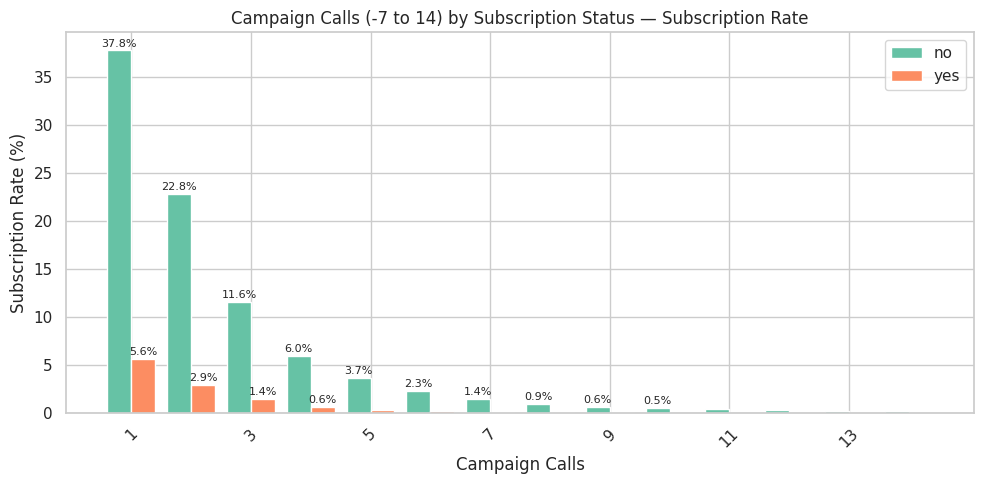

In [28]:
# Filter Campaign Calls between -7 and 14
df_calls = df[df['Campaign Calls'].between(-7, 14)]

plt.figure(figsize=(10,5))

# Compute total percentage per Campaign Calls per Subscription Status
count_table = df_calls.groupby(['Campaign Calls', 'Subscription Status']).size().unstack(fill_value=0)

# Percentage of total
pct_table = (count_table / count_table.values.sum()) * 100

# Plot bars
x = np.arange(len(pct_table.index))
width = 0.4

plt.bar(x - width/2, pct_table['no'], width, label='no', color='#66c2a5')
plt.bar(x + width/2, pct_table['yes'], width, label='yes', color='#fc8d62')

# Add percentage labels on top, only for values > 0.5% to avoid clutter
for i, val in enumerate(pct_table['no']):
    if val > 0.5:
        plt.text(i - width/2, val + 0.2, f"{val:.1f}%", ha='center', va='bottom', fontsize=8)
for i, val in enumerate(pct_table['yes']):
    if val > 0.5:
        plt.text(i + width/2, val + 0.2, f"{val:.1f}%", ha='center', va='bottom', fontsize=8)

# Show only every other tick on x-axis to reduce clutter
plt.xticks(x[::2], pct_table.index[::2], rotation=45)
plt.title("Campaign Calls (-7 to 14) by Subscription Status — Subscription Rate")
plt.xlabel("Campaign Calls")
plt.ylabel("Subscription Rate (%)")
plt.legend()
plt.tight_layout()
plt.show()


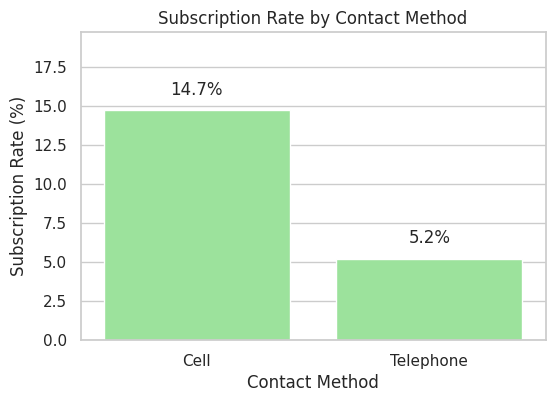

In [29]:
# Compute subscription rate by contact method
contact_rate = df.groupby('Contact Method')['SubBin'].mean().reset_index()

# Convert to percentage
contact_rate['SubPercent'] = contact_rate['SubBin'] * 100

# Plot bar chart
plt.figure(figsize=(6,4))
sns.barplot(data=contact_rate, x='Contact Method', y='SubPercent', color='lightgreen')
plt.title("Subscription Rate by Contact Method")
plt.xlabel("Contact Method")
plt.ylabel("Subscription Rate (%)")
plt.ylim(0, contact_rate['SubPercent'].max() + 5)

# Add percentage labels on bars
for index, row in contact_rate.iterrows():
    plt.text(index, row.SubPercent + 1, f"{row.SubPercent:.1f}%", ha='center')

plt.show()


In [31]:
df_corr = df.copy()
df_corr['Subscription Status'] = df_corr['Subscription Status'].map({'yes':1,'no':0})

In [33]:
import sqlite3

# Define the path for the new cleaned database
db_clean_path = "/content/bmarket_clean.db"

# Create a new SQLite connection
conn_clean = sqlite3.connect(db_clean_path)

# Save the cleaned DataFrame to a new table in the database
# 'if_exists='replace'' will overwrite the table if it already exists
df.to_sql('bank_marketing_clean', conn_clean, if_exists='replace', index=False)

# Close the connection to the new database
conn_clean.close()

print(f"Cleaned data saved to {db_clean_path} in table 'bank_marketing_clean'")

Cleaned data saved to /content/bmarket_clean.db in table 'bank_marketing_clean'


In [34]:
# Verify the saved data by loading it back
conn_verify = sqlite3.connect(db_clean_path)
df_verify = pd.read_sql_query("SELECT * FROM bank_marketing_clean", conn_verify)
conn_verify.close()

print("\nFirst 5 rows of the verified cleaned data from bmarket_clean.db:")
display(df_verify.head())


First 5 rows of the verified cleaned data from bmarket_clean.db:


,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,SubBin
0,32885,57,technician,married,high.school,no,no,yes,Cell,1,999,no,0
1,3170,55,retired,married,university.degree,no,yes,no,Telephone,2,999,no,0
2,32207,33,blue-collar,married,basic.9y,no,no,no,Cell,1,999,no,0
3,9404,36,admin.,married,high.school,no,no,no,Telephone,4,999,no,0
4,14021,27,housemaid,married,high.school,no,None,no,Cell,2,999,no,0


In [35]:
import sqlite3

# Path to your new clean database file
clean_db_path = "bmarket_clean.db"

# Connect (this will create the file if it doesn't exist)
conn = sqlite3.connect(clean_db_path)

# Save df to a new table
df.to_sql(
    name="bank_marketing_clean",
    con=conn,
    if_exists="replace",   # overwrite if the table already exists
    index=False            # no row index column
)

conn.close()

print("Clean database saved as:", clean_db_path)


Clean database saved as: bmarket_clean.db
